# Single Gradient Attribution


In [4]:
%%capture
! bash drive/MyDrive/paraMem/setup.sh

In [2]:
#@title Import libraries
import transformer_lens
import torch, gc
import pandas as pd

import sys
sys.path.append('drive/MyDrive/')
from paraMem.utils import metrics, helpers, data_loaders

## Model

In [3]:
DEVICE = "cpu"
gc.collect()
torch.cuda.empty_cache()
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small").to(DEVICE)
model.set_use_attn_result(True)

def set_no_grad(model, no_grad:list=["embed", "pos_embed", "unembed"]):
  """
  explicitely set or remove parameters that do not require gradient
  """
  #if any("abc" in s for s in xs):
  for name, param in model.named_parameters():
    for name_part in name.split("."):
      if name_part in no_grad:
        param.requires_grad = False
#set_no_grad(model)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


## Load Data

In [4]:
prefix_BI = model.to_tokens("Twinkle, twinkle, little star, how I wonder what you are. Up above the world so high, like a diamond in the sky. Twinkle, twinkle, little star, how I wonder what you are.")
model.to_string(prefix_BI)

['<|endoftext|>Twinkle, twinkle, little star, how I wonder what you are. Up above the world so high, like a diamond in the sky. Twinkle, twinkle, little star, how I wonder what you are.']

## Metric

In [156]:
def get_topK(scores:torch.FloatTensor, topK:int=None):
    """
    return the topK scores and token indeces
    """
    if topK is None:
        topK = scores.shape[-1]
    top_scores, top_indc = torch.topk(scores, topK, dim=-1)
    return top_scores, top_indc


def NLL_loss(logits:torch.FloatTensor, labels:torch.LongTensor=None):
    """
    standard negative log likelihood loss for language modeling
    """
    log_probs = -(logits.log_softmax(dim=-1)) ## negative log probs #.to(torch.float64)
    if labels.shape[-2] == 1:
      log_probs = log_probs.gather(dim=-1, index=labels[:, 1:, None])[:, :, 0] ## batch, toks
    elif labels.shape[-2] > 1:
      log_probs = log_probs.gather(dim=-1, index=labels[:, 1:]) ## batch, toks
      log_probs = log_probs.mean(-1) ## mean over top token options
    log_probs = log_probs.mean(-1) ## mean over sequence length
    log_probs = log_probs.mean(0) ## mean over batch dimension
    return log_probs


def contrast_metric(model, prefix_BI:torch.LongTensor):
    """
    maximizing keep_score while minimizing change_score
    """

    logits_BI = model(prefix_BI)
    _, top_labels_BIT = get_topK(logits_BI)

    change_NNL = NLL_loss(logits_BI, top_labels_BIT[...,:,:1])
    keep_NNL = NLL_loss(logits_BI, top_labels_BIT[...,:,1:100])
    #contrast_score = (change_NNL - keep_NNL).mean(-1)
    contrast_score = change_NNL - keep_NNL
    print(f"keep_NNL: {keep_NNL}, change_NNL: {change_NNL}, contrast_score: {contrast_score}")
    return contrast_score

## Parameter Gradient Attribution

In [157]:
contrast_score = contrast_metric(model, prefix_BI)
contrast_score.backward(retain_graph = False)

keep_NNL: 11.122586250305176, change_NNL: 8.677130699157715, contrast_score: -2.445455551147461


In [158]:
def collect_param_gradient(model, pool_hid:str="mean_abs"):

  pool_fn = {"mean_abs": lambda x: torch.mean(torch.abs(x)),
             "max_abs": lambda x: torch.max(torch.abs(x)),
             "pass": lambda x: (x)}

  names, grads = [], []
  for name, param in model.named_parameters():
    if param.grad is not None:
      param_grad = param.grad.detach().cpu()

      ## pool out batch dimension, but keep
      param_grad = param_grad.mean(0).unsqueeze(0)

      grad = pool_fn[pool_hid](param_grad).item()
      #print(f"{name}: {attr}")
      names.append(name.split(".")), grads.append(grad)
  return names, grads

names, grads = collect_param_gradient(model)

<ipython-input-159-951a3113cd1c>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  layer_module_df.pivot(1, 2, "grads").plot(kind='bar')


<Axes: xlabel='1'>

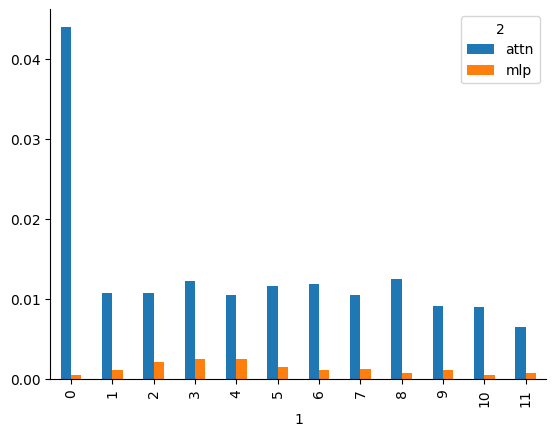

In [159]:
df = pd.DataFrame(list(zip(names,grads)), columns=['names','grads'])
df = pd.concat((df["names"].apply(pd.Series), df["grads"]), axis=1)

## group by layer and module type________________________________
layer_module_df = df.groupby([1,2]).agg({'grads': 'mean'}).reset_index()
layer_module_df[1] = layer_module_df[1].astype(int)
layer_module_df = layer_module_df.sort_values(by=[1, 2], ascending=True)
layer_module_df.pivot(1, 2, "grads").plot(kind='bar')

## Parameter Gradient Attribution

In [160]:
hook_filter = lambda name: "_input" not in name
#hook_filter = lambda name: "resid_pre" in name or 'resid_post' in name

def get_cache_fwd_and_bwd(model, prefix_BI, metric):
    model.reset_hooks()
    cache = {}

    #def forward_cache_hook(act, hook):
    #    cache[hook.name] = act.detach()
    #model.add_hook(hook_filter, forward_cache_hook, "fwd")

    grad_cache = {}
    def backward_cache_hook(act, hook):
        #print(hook.name, act, "/n")
        grad_cache[hook.name] = act.detach()
    model.add_hook(hook_filter, backward_cache_hook, "bwd")


    contrast_score = metric(model, prefix_BI)
    contrast_score.backward(retain_graph=False)
    model.reset_hooks()
    return contrast_score.item(), transformer_lens.ActivationCache(cache, model), transformer_lens.ActivationCache(grad_cache, model)

model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
metric_score, fwd_cache, bwd_cache = get_cache_fwd_and_bwd(model, prefix_BI, contrast_metric)


keep_NNL: 11.122586250305176, change_NNL: 8.677130699157715, contrast_score: -2.445455551147461


In [161]:
def collect_activs(activ_cache, pool_toks:str="pass", pool_hid:str="mean_abs"):
  #clean_grad_cache["pattern", 0, "attn"].shape
  #accumulated_resid(-1, incl_mid=True, return_labels=True)

  pool_fn = {"mean_abs": lambda x, dim: torch.mean(torch.abs(x), dim=dim),
             "max_abs": lambda x, dim: torch.max(torch.abs(x), dim=dim),
             "pass": lambda x, dim: (x)}

  names, activs = [], []
  for name, activ in activ_cache.items():
    activ = activ.detach().cpu()
    activ = activ.mean(0).unsqueeze(0) ## pool out batch dimension, but keep

    activ = pool_fn[pool_hid](activ,dim=-1)
    activ = pool_fn[pool_toks](activ,dim=-1)
    names.append(name.split(".")), activs.append(activ.tolist())
  return names, activs

#names, activs = collect_activs(bwd_cache)
#df = pd.DataFrame(list(zip(names,activs)), columns=['names','activs'])
#df = pd.concat((df["names"].apply(pd.Series), df["activs"]), axis=1)

## Analyse Activation Gradients

In [162]:
#hook_filter = lambda name: "_input" not in name
#[transformer_lens.utils.get_act_name("resid_post", layer) for layer in range(model.cfg.n_layers)]
#bwd_residual, residual_labels = bwd_cache.accumulated_resid(-1, incl_mid=False, return_labels=True)
bwd_cache

ActivationCache with keys ['ln_final.hook_normalized', 'ln_final.hook_scale', 'blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.mlp.hook_post', 'blocks.11.mlp.hook_pre', 'blocks.11.ln2.hook_normalized', 'blocks.11.ln2.hook_scale', 'blocks.11.hook_mlp_in', 'blocks.11.hook_resid_mid', 'blocks.11.hook_attn_out', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_z', 'blocks.11.attn.hook_pattern', 'blocks.11.attn.hook_attn_scores', 'blocks.11.attn.hook_v', 'blocks.11.attn.hook_k', 'blocks.11.attn.hook_q', 'blocks.11.ln1.hook_normalized', 'blocks.11.ln1.hook_scale', 'blocks.11.hook_attn_in', 'blocks.11.hook_resid_pre', 'blocks.10.hook_resid_post', 'blocks.10.hook_mlp_out', 'blocks.10.mlp.hook_post', 'blocks.10.mlp.hook_pre', 'blocks.10.ln2.hook_normalized', 'blocks.10.ln2.hook_scale', 'blocks.10.hook_mlp_in', 'blocks.10.hook_resid_mid', 'blocks.10.hook_attn_out', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_z', 'blocks.10.attn.hook_pattern', 'blocks.10.attn.hook_attn_s

In [167]:
activ_names = [transformer_lens.utils.get_act_name("mlp_out", layer) for layer in range(model.cfg.n_layers)]
bwd_residual = torch.stack([bwd_cache[activ_name] for activ_name in activ_names])
bwd_residual = torch.abs(bwd_residual).mean(1).mean(-1) ## "mlp_out"
#bwd_residual = torch.abs(bwd_residual).mean(1).mean(-1).mean(-1) ## "k", "q", "v"
#bwd_residual, _ = torch.max(torch.abs(bwd_residual).mean(1).mean(-1), dim=-1) ## "k", "q", "v"

#bwd_residual = torch.abs(bwd_residual).mean(1).mean(-1)[...,10] ## "k", "q", "v"
print(f"{activ_names}\n{bwd_residual.shape}")

['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out', 'blocks.2.hook_mlp_out', 'blocks.3.hook_mlp_out', 'blocks.4.hook_mlp_out', 'blocks.5.hook_mlp_out', 'blocks.6.hook_mlp_out', 'blocks.7.hook_mlp_out', 'blocks.8.hook_mlp_out', 'blocks.9.hook_mlp_out', 'blocks.10.hook_mlp_out', 'blocks.11.hook_mlp_out']
torch.Size([12, 47])


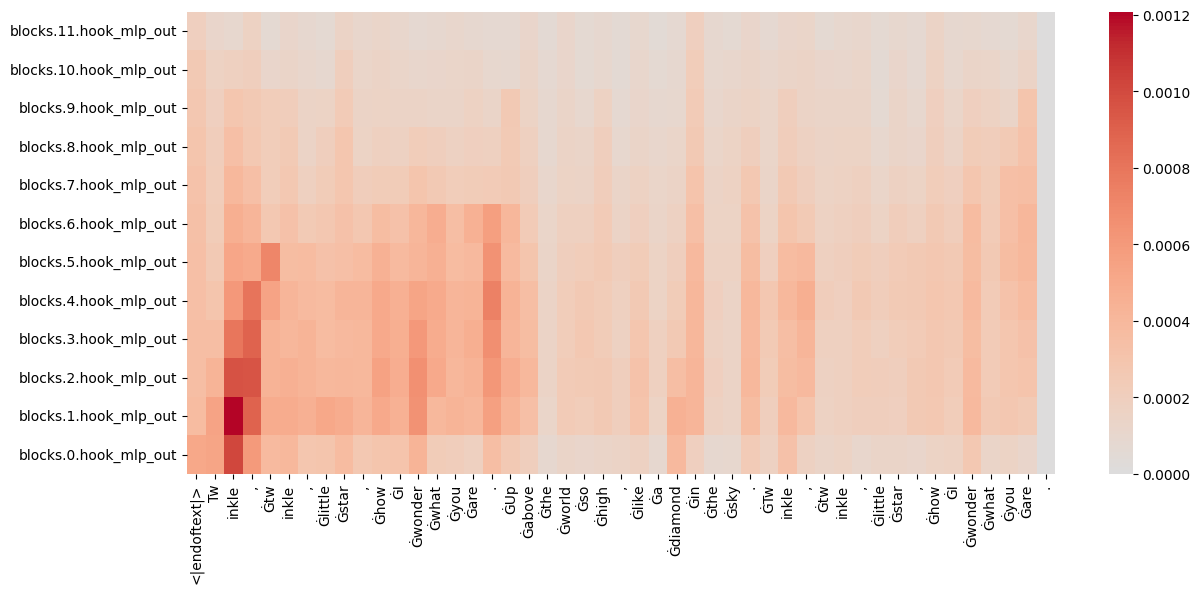

In [168]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
ax = sns.heatmap(bwd_residual, cmap=mpl.colormaps["coolwarm"], center=0,
                 xticklabels=model.tokenizer.convert_ids_to_tokens(prefix_BI.squeeze()),
                 yticklabels=activ_names, square=False)
ax.invert_yaxis()